In [1]:
%matplotlib inline

In [2]:
from vgg16 import Vgg16
from utils import plots
import matplotlib

Using Theano backend.


In [3]:
path = '/mnt/data/dogscats/'
batch_size = 64

In [4]:
vgg = Vgg16()

In [ ]:
batches = vgg.get_batches(path=path + 'train', batch_size=batch_size)
val_batches = vgg.get_batches(path=path + 'valid', batch_size=batch_size*2)
vgg.finetune(batches)
vgg.fit(batches, val_batches, nb_epoch=1)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/1
19648/23000 [========================>.....] - ETA: 6435s - loss: 0.1445 - acc: 0.9624

In [19]:
imgs, labels = next(batches)

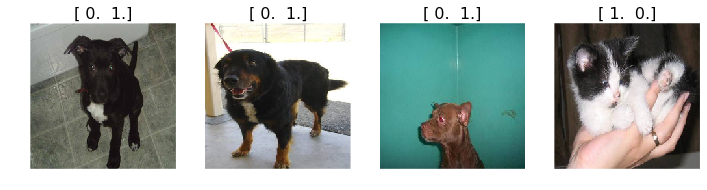

In [20]:
plots(imgs, titles=labels)

In [21]:
vgg.predict(imgs, True)

(array([ 0.1872,  0.1854,  0.3369,  0.2521], dtype=float32),
 array([195, 214, 736, 377]),
 [u'Boston_bull', u'Gordon_setter', u'pool_table', u'marmoset'])

In [23]:
vgg.classes[:4]

[u'tench', u'goldfish', u'great_white_shark', u'tiger_shark']

## Kaggle Competition

In [5]:
%matplotlib inline
from vgg16 import Vgg16
from utils import plots
from utils import save_array
from utils import load_array
from keras.models import Sequential
from keras.models import load_model
import numpy as np
import pandas as pd
from keras.preprocessing import image

Using TensorFlow backend.


In [6]:
vgg = Vgg16()

## Helper Vars

In [44]:
load_model = True
load_preds = False
load_troubleshoot = False
clip_preds = True
training_epochs = 2
saved_model_epochs = 2
clip_lb = 0.025
clip_ub = 0.975

## Setup Paths

In [ ]:
results_path = '/mnt/results/dogscats/'
model_save_path = '/mnt/models/dogscats/'
train_path = '/mnt/data/dogscats/kaggle/' + 'train/'
val_path = '/mnt/data/dogscats/kaggle/' + 'valid/'
test_path = '/mnt/data/dogscats/kaggle/' + 'test/'
batch_size = 64

## Setup batch generators

In [9]:
batches = vgg.get_batches(train_path, batch_size=batch_size)
val_batches = vgg.get_batches(val_path, batch_size=2*batch_size)
test_batches = vgg.get_batches(test_path, batch_size=2*batch_size, class_mode=None)

Found 20002 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


In [10]:
vgg.finetune(batches)
if not load_model:
    for epoch in range(1, training_epochs + 1):
        vgg.fit(batches, val_batches, nb_epoch=saved_model_epochs)
        vgg.model.save_weights(model_save_path + 'ft' + str(epoch) + '.h5')    
    saved_model_epochs = training_epochs

## Load Model

In [33]:
vgg.model.load_weights(model_save_path + 'ft' + str(saved_model_epochs) + '.h5')

## Predict

In [29]:
if not load_preds:
    batches, preds = vgg.test(test_path, batch_size=2*batch_size)

Found 12500 images belonging to 1 classes.


## Clip Predictions

In [45]:
if clip_preds:
    preds = np.clip(preds, clip_lb, clip_ub)

## Save Predictions

In [47]:
if not load_preds:
    save_array(results_path + 'preds' + str(saved_model_epochs) + '.dat', preds)
    save_array(results_path + 'filenames' + str(saved_model_epochs) + '.dat', batches.filenames)

## Load Predictions

In [48]:
preds = load_array(results_path + 'preds' + str(saved_model_epochs) + '.dat')
filenames = load_array(results_path + 'filenames' + str(saved_model_epochs) + '.dat')

## Troubleshooting

In [16]:
if not load_troubleshoot:
    batches, preds = vgg.test(val_path, batch_size=2*batch_size)
    labels = batches.classes
    filenames = batches.filenames
    df = pd.DataFrame({'label': labels, 'prob': preds[:, 1], 
                   'pred': np.round(preds[:, 1]), 'filename': filenames})
    df.to_pickle(results_path + 'val_preds.pkl')

In [17]:
if load_troubleshoot:
    df = pd.read_pickle(results_path + 'val_preds.pkl')

In [18]:
n_view = 4
def plot_idx(df, titles=None):
    plots([image.load_img(val_path + rows['filename']) for index, rows in df.iterrows()], titles=titles)

### 5 random examples - Correct

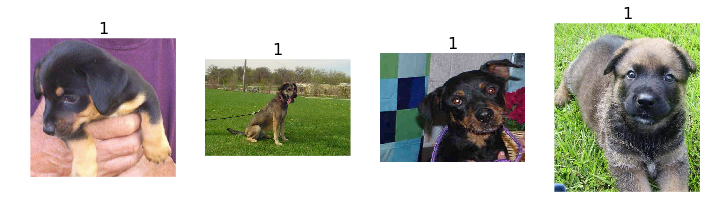

In [19]:
sel = df.loc[df.label == df.pred].sample(n_view)
plot_idx(sel, titles=list(sel.label))

## 5 random examples - incorrect

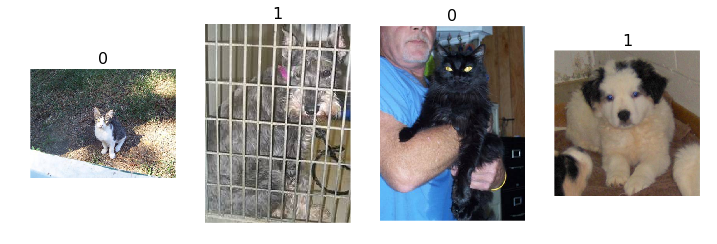

In [21]:
sel = df.loc[df.label != df.pred].sample(n_view)
plot_idx(sel, titles=list(sel.label))

## 5 Dog examples - most correct

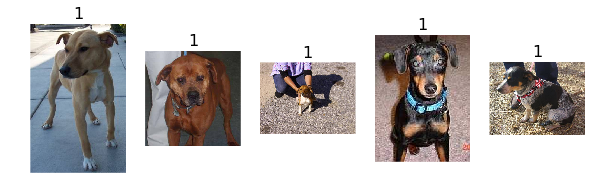

In [24]:
sel = df.loc[df.label == 1].sort_values('prob', ascending=False).iloc[0:5]
plot_idx(sel, titles=list(sel.label))

## 5 Cat examples - most correct

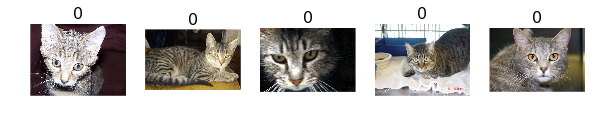

In [25]:
sel = df.loc[df.label == 0].sort_values('prob', ascending=True).iloc[0:5]
plot_idx(sel, titles=list(sel.label))

## 5 Dog examples - most incorrect

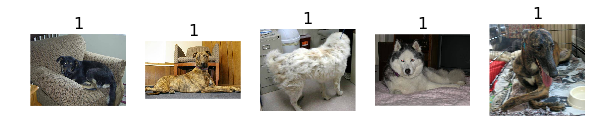

In [26]:
sel = df.loc[df.label == 1].sort_values('prob', ascending=True).iloc[0:5]
plot_idx(sel, titles=list(sel.label))

## 5 cat examples - most incorrect

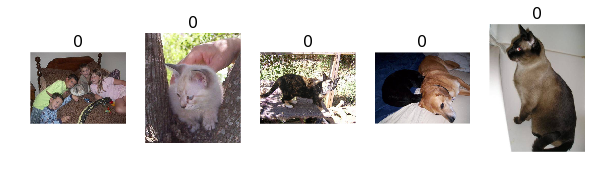

In [28]:
sel = df.loc[df.label == 0].sort_values('prob', ascending=False).iloc[0:5]
plot_idx(sel, titles=list(sel.label))

## 5 dog examples - most uncertain

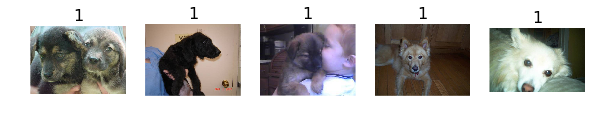

In [35]:
sel = df.loc[df.label == 1].copy().assign(certainty=abs(df.prob-0.5))
sel = sel.sort_values('certainty', ascending=True).iloc[0:5]
plot_idx(sel, titles=list(sel.label))

## 5 cat examples - most uncertain

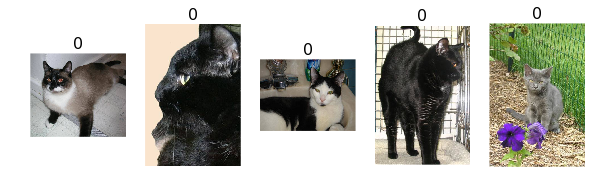

In [20]:
sel = df.loc[df.label == 0].copy().assign(certainty=abs(df.prob-0.5))
sel = sel.sort_values('certainty', ascending=True).iloc[0:5]
plot_idx(sel, titles=list(sel.label))

## Prepare Submission

In [49]:
ids = [int(f[5:f.find('.')]) for f in filenames]
subm = np.stack([ids, preds[:, 1]], axis=1)

## Save submission

In [50]:
np.savetxt(results_path + 'subm' + str(saved_model_epochs) + '.csv', subm, 
           fmt='%d,%.5f', header='id,label', comments='')